# Marco Lavorini - Assignment 3

### dataset
Vito,Saverio. (2016). Air Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Fetching the dataset

In [7]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [8]:
# drop columns except for the target column 
df = X.drop(['Date','Time','CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH'], axis=1)
df = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)']]
# the null values are marked as '-200'
df = df[df['C6H6(GT)'] != -200]
df = df[df['PT08.S1(CO)'] != -200]
df = df[df['PT08.S2(NMHC)'] != -200]
df = df[df['PT08.S3(NOx)'] != -200]
df = df[df['PT08.S4(NO2)'] != -200]
df = df[df['PT08.S5(O3)'] != -200]


In [9]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),C6H6(GT)
0,1360,1046,1056,1692,1268,11.9
1,1292,955,1174,1559,972,9.4
2,1402,939,1140,1555,1074,9.0
3,1376,948,1092,1584,1203,9.2
4,1272,836,1205,1490,1110,6.5


# Data splitting

we decided to split the dataset, leaving a 20% of the data out, untouched, for testing. The remaining data was further divided in 80% for train and 20% for validation.

In [10]:
# split into train and test sets
dataset = df.values

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(f'train: {train_size}, validation: {validation_size}, test: {test_size}')

train: 5754, validation: 1438, test: 1799


The data was scaled only on the true train test, without the validation or test set. This is done to fit the scaler only on the training set without the 'future' data which in a real scenario should not be known.

In [11]:
# normalize the dataset
X_ = dataset[:, :-1]
y_ = dataset[:, -1]
train_X, train_y = X_[:train_size], y_[:train_size]
validation_X, validation_y = X_[train_size:train_size+validation_size], y_[train_size:train_size+validation_size]
test_X, test_y = X_[train_size+validation_size:], y_[train_size+validation_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
validation_X = scaler.transform(validation_X)
test_X = scaler.transform(test_X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
validation_y = scaler_y.transform(validation_y.reshape(-1, 1))
test_y = scaler_y.transform(test_y.reshape(-1, 1))

# First model: LSTM

We choose an LSTM neural network as the first model to predict the benzene, based on the PT08.* measurement. To create the model we used Keras which offers an easy LSTM layer implementation [2] in the standard Sequential model. The data is then reshaped accordingly to the documentation where it must have the shape (batch, timesteps, feature).

[2] https://keras.io/api/layers/recurrent_layers/lstm/

In [12]:
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
validation_X = np.reshape(validation_X, (validation_X.shape[0], 1, validation_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

(5754, 5) (5754, 1) (1438, 5) (1438, 1) (1799, 5) (1799, 1)
(5754, 1, 5) (5754, 1) (1438, 1, 5) (1438, 1) (1799, 1, 5) (1799, 1)


In [13]:
model =  Sequential()

model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(16))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [14]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

None


# Training the first model

It is important to notice that here the parameter 'shuffle' was set to False since we are working with a time-series.

In [15]:
history = model.fit(train_X, train_y, validation_data=[validation_X, validation_y], epochs=15, batch_size=64, verbose=False, shuffle=False)

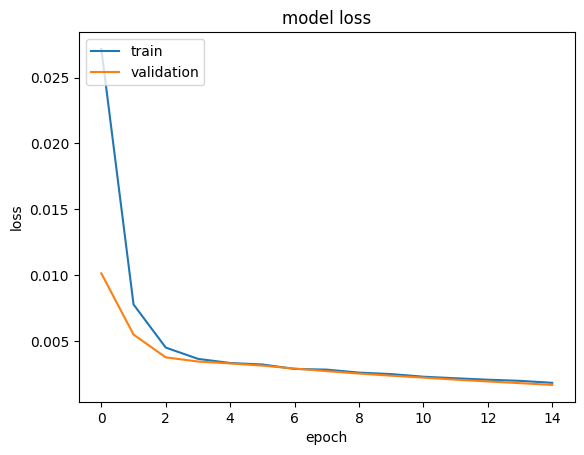

In [16]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Rescaling the data back

In [17]:
predict = model.predict(test_X)
predict = scaler_y.inverse_transform(predict)
test_y = scaler_y.inverse_transform(test_y)
rmse = math.sqrt(mean_squared_error(test_y, predict))
print('Test RMSE: %.3f' % rmse)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test RMSE: 1.852


## Plotting the results

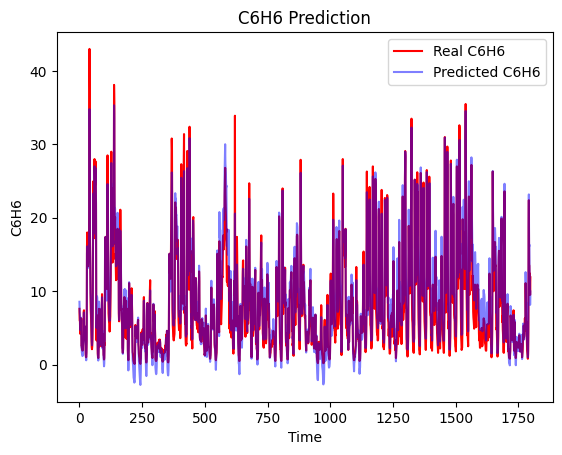

In [18]:
# plot the data
plt.plot(test_y, color = 'red', label = 'Real C6H6')
plt.plot(predict, color = 'blue', label = 'Predicted C6H6', alpha=0.5)
plt.title('C6H6 Prediction')

plt.xlabel('Time')
plt.ylabel('C6H6')
plt.legend()
plt.show()

zooming on the first 300 points

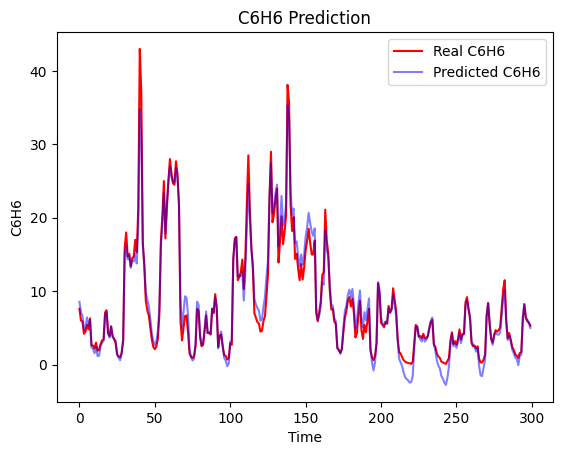

In [19]:
plt.plot(test_y[0:300], color = 'red', label = 'Real C6H6')
plt.plot(predict[0:300], color = 'blue', label = 'Predicted C6H6', alpha=0.5)
plt.title('C6H6 Prediction')
plt.xlabel('Time')
plt.ylabel('C6H6')
plt.legend()
plt.show()

---

# second model

Here we will use as inputs the current benzene value, and as output the one-step-ahead value.

## Creation of the the dataset

for each measurement of C6H6 we create the dataset $(\text{C6H6}_t, \text{C6H6}_{t+1})$

In [20]:
X_2, y_2 = [], []
for i in range(len(y_)-1):
    X_2.append(y_[i])
    y_2.append(y_[i+1])
X_2 = np.array(X_2)
y_2 = np.array(y_2)

print(X_2.shape, y_2.shape)

(8990,) (8990,)


In [21]:
# split into train and test sets
dataset = df.values
#calculate sizez
train_size = int(len(X_2) * 0.8)
test_size = len(X_2) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size
#perform the split
x_train, y_train = X_2[:train_size], y_2[:train_size]
x_validation, y_validation = X_2[train_size:train_size+validation_size], y_2[train_size:train_size+validation_size]
x_test, y_test = X_2[train_size+validation_size:], y_2[train_size+validation_size:]


Rescale the data as before, fitting the scaler only on the known data. 

In [22]:
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_validation = scaler.transform(x_validation.reshape(-1, 1))
x_test = scaler.transform(x_test.reshape(-1, 1))

y_train = scaler.transform(y_train.reshape(-1, 1))
y_validation = scaler.transform(y_validation.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1) (5754, 1) (1438, 1) (1438, 1) (1798, 1) (1798, 1)


Add the timestep needed for the LSTM layer

In [23]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

x_validation = np.reshape(x_validation, (x_validation.shape[0], 1, x_validation.shape[1]))

x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1, 1) (5754, 1) (1438, 1, 1) (1438, 1) (1798, 1, 1) (1798, 1)


# Model #2, same hyperparameter for comparison

In [24]:
model2 =  Sequential()

model2.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
model2.add(LSTM(16))
model2.add(Dropout(0.2))
model2.add(Dense(1))

model2.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
print(model2.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

None


Train phase with the same settings

In [26]:
history = model2.fit(x_train, y_train, validation_data=[x_validation, y_validation], epochs=15, batch_size=64, verbose=False, shuffle=False)

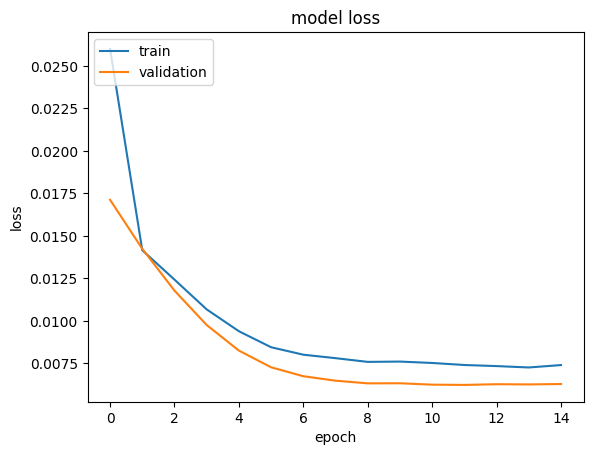

In [27]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## Results for model #2

In [28]:
predict2 = model2.predict(x_test)

predict2 = scaler.inverse_transform(predict2)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [29]:
# calculate root mean squared error
y_test = scaler.inverse_transform(y_test)
rmse2 = math.sqrt(mean_squared_error(y_test, predict2))
print('Test RMSE: %.3f' % rmse2)


Test RMSE: 3.847


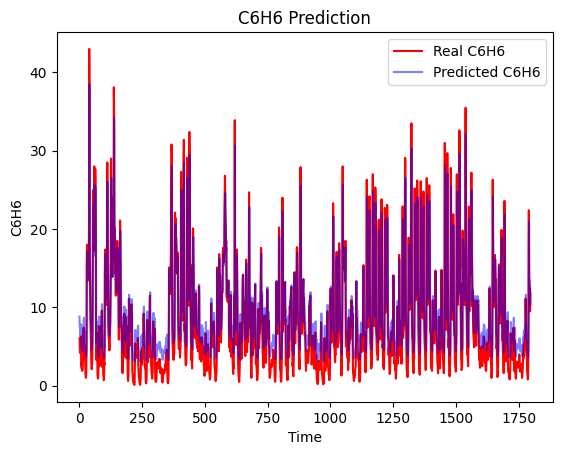

In [30]:
# plot the data
plt.plot(y_test, color = 'red', label = 'Real C6H6')
plt.plot(predict2, color = 'blue', label = 'Predicted C6H6', alpha=0.5)
plt.title('C6H6 Prediction')

plt.xlabel('Time')
plt.ylabel('C6H6')
plt.legend()
plt.show()

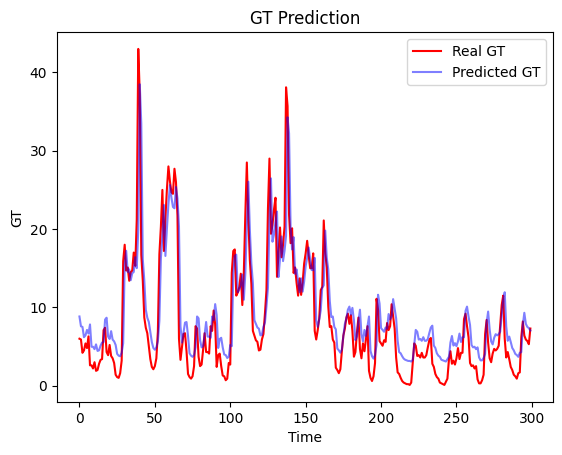

In [31]:
# plot the data
plt.plot(y_test[:300], color = 'red', label = 'Real GT')
plt.plot(predict2[:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

# Conclusions

For our experimental setup we decided to use LSTM networks for both tasks. The data was splitted in a 80% for training/validation and the remaining 20% for testing, scaling accordingly based only on the data used for training and without shuffling to keep the data time-coherent. The performance of each model was assessed using RMSE.

The first model, based on 4 sensor measurement of the PT08.* columns effectively captured the relationship between sensor data and benzene levels.

The LSTM model designed for one-step-ahead prediction of benzene based on its current value had slightly lower (but still good) performance, suggesting that, while current benzene levels provide useful information, incorporating sensor measurements is a better choice.

Performance Comparison:

- The sensor-based prediction model outperformed the one-step-ahead model. Sensor data provides a better understanding of the factors influencing benzene levels, leading to more accurate predictions.
- The one-step-ahead model, while slightly less accurate, still provides good results, and could be useful in scenarios where sensor data might not be available.